In [ ]:
# !export CUDA_VISIBLE_DEVICES=0,1

In [20]:
from fastai.vision.all import *
import timm
from fastcore.parallel import *

In [5]:
Path.BASE_PATH = path = Path.home()/'.fastai/data/paddy'; path.ls()

(#4) [Path('sample_submission.csv'),Path('train.csv'),Path('train_images'),Path('test_images')]

In [6]:
df = pd.read_csv(path/'train.csv'); df

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [7]:
trn_path = path/'train_images'; trn_path

Path('train_images')

In [8]:
files = get_image_files(path/'train_images')

In [9]:
img = PILImage.create(files[0])

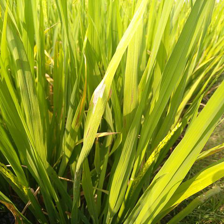

In [10]:
img.resize((224,224))

In [41]:
%time pd.DataFrame([str(PILImage.create(o).size) for o in files],columns =['dims']).value_counts()

CPU times: user 34 s, sys: 250 ms, total: 34.2 s
Wall time: 34.3 s


dims      
(480, 640)    10403
(640, 480)        4
dtype: int64

In [42]:
def f(o): return str(PILImage.create(o).size)

In [43]:
%time sizes = parallel(f, files, n_workers=8)

CPU times: user 3.4 s, sys: 811 ms, total: 4.21 s
Wall time: 10.8 s


In [44]:
%time pd.DataFrame(list(sizes)).value_counts()

CPU times: user 8.63 ms, sys: 29 µs, total: 8.66 ms
Wall time: 6.99 ms


(480, 640)    10403
(640, 480)        4
dtype: int64

In [12]:
df.variety.value_counts()

ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: variety, dtype: int64

In [45]:
df.label.value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

In [46]:
img.size

(480, 640)

In [47]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42, item_tfms=Resize(224))

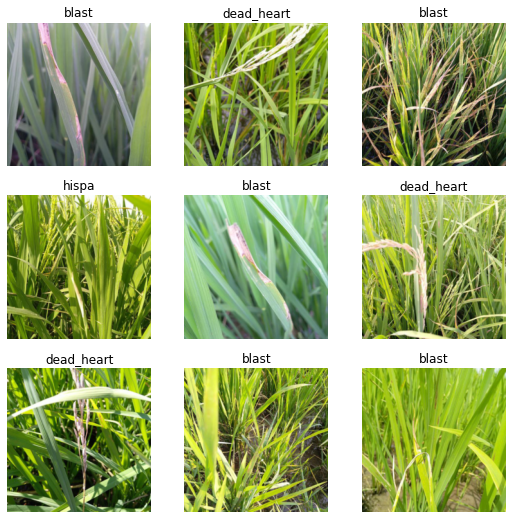

In [48]:
dls.show_batch()

# timm.list_models('*convnext*')

In [50]:
learn = vision_learner(dls, 'convnext_base_in22k', metrics=error_rate)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_224.pth" to /home/bilal/.cache/torch/hub/checkpoints/convnext_base_22k_224.pth


In [51]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.356811,0.696821,0.224411,00:40


epoch,train_loss,valid_loss,error_rate,time
0,0.667171,0.370303,0.114849,02:05
1,0.463133,0.263403,0.080730,02:04
2,0.291507,0.182598,0.049976,02:04
3,0.183251,0.155596,0.045171,02:04
4,0.140281,0.145919,0.045171,02:04


In [52]:
interp = ClassificationInterpretation.from_learner(learn)

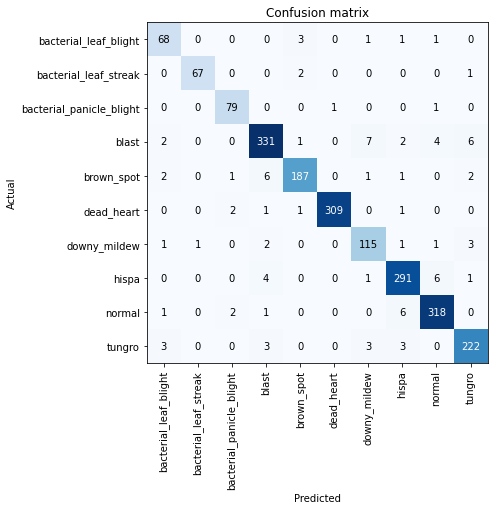

In [53]:
interp.plot_confusion_matrix(figsize=(7,7))

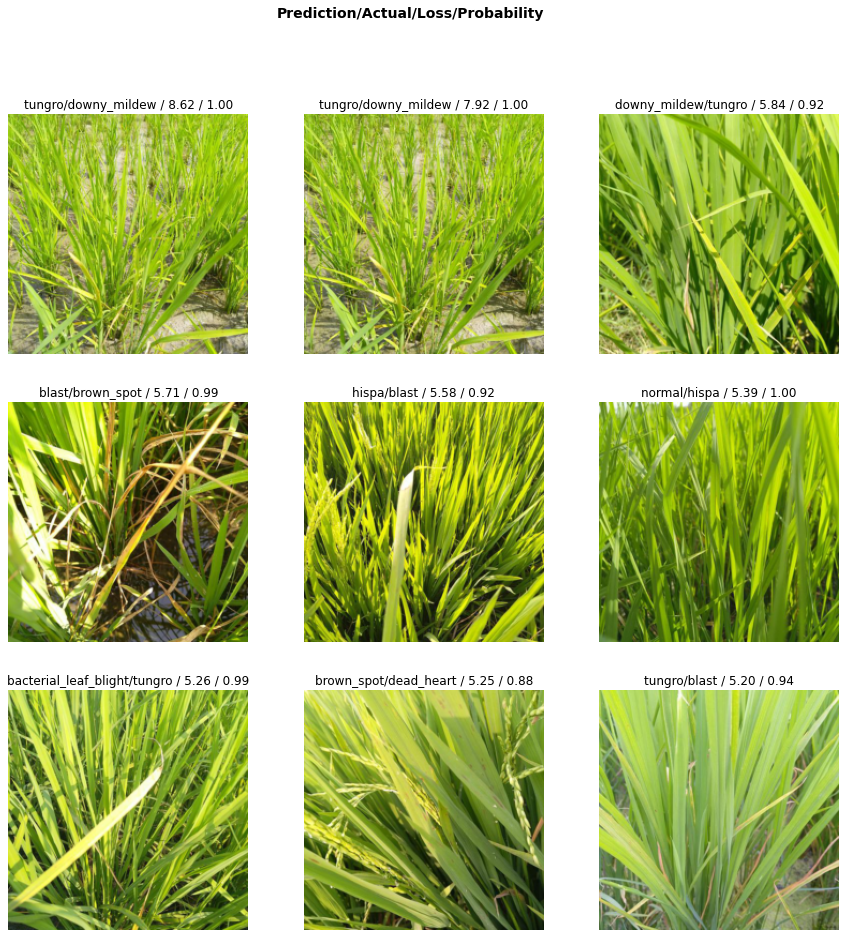

In [54]:
interp.plot_top_losses(9, figsize=(15,15))

In [ ]:
learn.export('paddle.pkl')

In [73]:
test_files = get_image_files(path/'test_images').sorted(); test_files

(#3469) [Path('test_images/200001.jpg'),Path('test_images/200002.jpg'),Path('test_images/200003.jpg'),Path('test_images/200004.jpg'),Path('test_images/200005.jpg'),Path('test_images/200006.jpg'),Path('test_images/200007.jpg'),Path('test_images/200008.jpg'),Path('test_images/200009.jpg'),Path('test_images/200010.jpg')...]

In [74]:
test_dl = dls.test_dl(test_files)

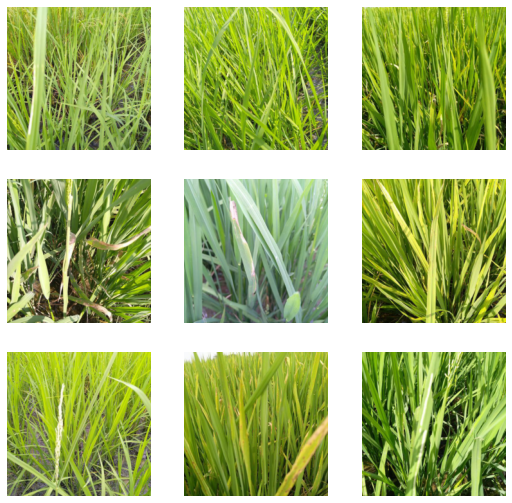

In [75]:
test_dl.show_batch()

In [84]:
my_submission_df = pd.read_csv(path/'sample_submission.csv'); my_submission_df

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [79]:
probs, _, idxs = learn.get_preds(dl=test_dl, with_decoded=True)

In [80]:
idxs = pd.Series(idxs.numpy(), name="idxs")

In [81]:
mapping = {k:v for k,v in enumerate(dls.vocab)}; mapping

{0: 'bacterial_leaf_blight',
 1: 'bacterial_leaf_streak',
 2: 'bacterial_panicle_blight',
 3: 'blast',
 4: 'brown_spot',
 5: 'dead_heart',
 6: 'downy_mildew',
 7: 'hispa',
 8: 'normal',
 9: 'tungro'}

In [82]:
results = idxs.map(mapping);results

0            hispa
1           normal
2            blast
3            blast
4            blast
           ...    
3464    dead_heart
3465         hispa
3466        normal
3467         hispa
3468    dead_heart
Name: idxs, Length: 3469, dtype: object

In [85]:
my_submission_df['label'] = results

In [88]:
my_submission_df.to_csv('my_submission.csv', index=False)

In [87]:
my_submission_df

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,blast
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,hispa
3466,203467.jpg,normal
3467,203468.jpg,hispa
